# Foundry - All Boiler Inspections

## Environment Setup

In [1]:
import difflib
import json
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import os
import pandas as pd
import requests
import seaborn as sns
import sys
sys.path.insert(0, '..')
import warnings
import zlib

# local
from libs.etl.data_cleaning import generate_aep_outage_dfs, generate_duke_outage_dfs, generate_iir_boilers_dfs, determine_component
from libs.inspection_analysis.utils import analyze_inspection_df, hist_inspection_df, check_thickness, get_thickness_histogram, group_critdat, get_inspection_df
from libs.interfaces.rolodex_interface import rolodex_load
from libs.reference.constants import COMPONENT_TYPE_MAP, POWER_CUST_LIST
from libs.viz.utils import add_vbar_labels, add_hbar_labels

## Settings

In [2]:
plt.style.use('dark_background')
#sns.set_style('darkgrid')

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

warnings.filterwarnings('ignore')

wd = os.getcwd()
print(wd)

C:\Users\tom.fiorelli\Documents\GitHub\davos-data-project\notebooks


## Read in US Boiler data from IIR

In [3]:
us_boilers_df, operational_us_boilers_df = generate_iir_boilers_dfs()

In [4]:
us_boilers_df.shape

(2538, 53)

In [5]:
us_boilers_df.head(1)

,PARENTNAME,OWNER_NAME,OPER_NAME,PLANT_NAME,PHYS_CITY,P_COUNTY,UNIT_STATE,P_ST_NAME,P_COUNTRY,MARKET_REG,WORLD_REG,IND_CODE_DESC,SIC_CODE,PLANT_ID,UNIT_NAME,UNIT_ID,UNIT_TYPE,OUT_DESIGN,KO_DATE,STARTUP,STARTYEAR,SHUTDOWN,PRIM_FUEL,SECND_FUEL,FUEL_GROUP,HEAT_RATE,PWR_USAGE,U_STATUS,BOIL_NAME,BOILERTYPE,BMFR_NAME,BOIL_INFO,STEAM,STEAM_UOM,STEAM_TON,PRESSURE,PRES_UOM,PRES_BAR,TEMP,TEMP_UOM,TEMP_CEL,DESIGNFIRM,CONSTFIRM,MMBTU_HR,KO_YEAR,LATITUDE,LONGITUDE,COGEN_CHP,SHUTDOWN_dt,SHUTDOWN_yr,BOIL_CONFIG,BOIL_TYPE_Tag,Criticality
0,The Blackstone Group Incorporated,Lightstone Generation LLC,Lightstone Generation LLC,James Gavin Power Station,Cheshire,Gallia,OH,Ohio,U.S.A.,Great Lakes,North America,Power,4911,1010019,James Gavin 02,1003920,Steam Turbine,1300.0,NaN,1-Jul-75,1975,1-Dec-35,Coal Bituminous,Fuel Oil No. 2 Distillate Diesel,Coal,9799.0,Base Load,Operational,Boiler 02,Dry Bottom Boiler,Babcock & Wilcox,Opposed-Fired SCR LNB ESP-CS FGD-WS Trona,9775000.0,lbs/hr,4887.5,3685.0,PSIG,254.0,1010.0,deg F,543.0,AEP Pro Serv,AEP Pro Serv,NaN,NaN,38.9347,-82.1158,0,2035-12-01,2035.0,Opposed,Unknown,none


In [6]:
operational_us_boilers_df.to_csv('../data/outputs/operational_us_boilers.csv')

## Read in Rolodex inspection data 

In [7]:
data = rolodex_load(
    "inspection", 
    links=[
        "component", 
        "unit", 
        "site", 
        "organization"
    ], 
    filters=[
        {
            "type": "component", 
            "key": "portal.component_type", 
            "value": "1"
        }
    ], 
    ids=[], 
    tags={
    }, 
    limit=100000
)

In [8]:
boiler_inspections_df = pd.json_normalize(data)

In [9]:
boiler_inspections_df.shape

(857, 159)

In [10]:
boiler_inspections_df.head()

,entry.id,entry.type,entry.data.portal.id,entry.data.portal.date,entry.data.portal.demo,entry.data.portal.name,entry.data.portal.slug,entry.data.portal.notes,entry.data.portal.job_id,entry.data.portal.status,entry.data.portal.read_only,entry.data.portal.show_excel,entry.data.portal.sort_order,entry.data.portal.data_import,entry.data.portal.external_id,entry.data.portal.zero_offset,entry.data.portal.component_id,entry.data.portal.inspection_type,entry.data.portal.ndt_method_type,entry.data.portal.target_release_time,entry.data.portal.sales_robotic_service_id,entry.tags.job,entry.tags.site,entry.tags.unit,entry.tags.component,entry.tags.organization,links.component.id,links.component.type,links.component.data.portal.id,links.component.data.portal.lat,links.component.data.portal.lng,links.component.data.portal.name,links.component.data.portal.slug,links.component.data.portal.unit_id,links.component.data.portal.alloy_id,links.component.data.portal.contents,links.component.data.portal.sea_level,links.component.data.portal.description,links.component.data.portal.slope_angle,links.component.data.portal.temperature,links.component.data.portal.tube_spacing,links.component.data.portal.material_type,links.component.data.portal.salesforce_id,links.component.data.portal.tube_diameter,links.component.data.portal.component_type,links.component.data.portal.shell_diameter,links.component.data.portal.sales_asset_type_id,links.component.data.portal.wall_nominal_thickness,links.component.data.portal.wall_warning_thickness,links.component.data.portal.coating_nominal_thickness,links.component.data.portal.coating_warning_thickness,links.component.data.portal.difficulty_factor_percentage,links.component.tags.site,links.component.tags.unit,links.component.tags.organization,links.unit.id,links.unit.type,links.unit.data.portal.id,links.unit.data.portal.name,links.unit.data.portal.slug,links.unit.data.portal.capacity,links.unit.data.portal.latitude,links.unit.data.portal.fuel_type,links.unit.data.portal.longitude,links.unit.data.portal.built_date,links.unit.data.portal.description,links.unit.data.portal.location_id,links.unit.data.portal.total_tubes,links.unit.data.portal.salesforce_id,links.unit.data.portal.inspection_code,links.unit.data.portal.retirement_date,links.unit.data.portal.sales_asset_category_id,links.unit.data.portal.inspection_interval_years,links.unit.tags.site,links.unit.tags.organization,links.site.id,links.site.type,links.site.data.portal.id,links.site.data.portal.lat,links.site.data.portal.lng,links.site.data.portal.city,links.site.data.portal.name,links.site.data.portal.slug,links.site.data.portal.region,links.site.data.portal.country,links.site.data.portal.customer_id,links.site.data.portal.postal_code,links.site.data.portal.industry_type,links.site.data.portal.salesforce_id,links.site.data.portal.slack_channel,links.site.data.portal.address_line_1,links.site.data.portal.address_line_2,links.site.data.portal.drive_folder_id,links.site.tags.site,links.site.tags.organization,links.organization.id,links.organization.type,links.organization.data.portal.id,links.organization.data.portal.logo,links.organization.data.portal.name,links.organization.data.portal.slug,links.organization.data.portal.salesforce_id,links.organization.data.portal.drive_folder_id,links.organization.tags.organization,entry.tags.inspection,links.component.tags.component,links.unit.tags.unit,links.unit.data.display_name,links.unit.tags.radar_demo_id,links.site.data.values.gecko_customer,links.site.data.geometry.type,links.site.data.geometry.coordinates,links.site.data.plant_type,links.site.data.display_name,links.site.data.gecko_customer,links.site.tags.radar_demo_id,links.unit.data.values.color,links.unit.data.values.asset_type,links.unit.data.geometry.type,links.unit.data.geometry.coordinates,links.unit.data.components,links.unit.data.description,links.unit.data.manufactured_date,links.site.data.values.lost_mwh,links.site.data.values.plant_type,links.site.data.descr

In [92]:
boiler_inspections_df[boiler_inspections_df['entry.tags.organization'].str.contains('duke')]

,entry.id,entry.type,entry.data.portal.id,entry.data.portal.date,entry.data.portal.demo,entry.data.portal.name,entry.data.portal.slug,entry.data.portal.notes,entry.data.portal.job_id,entry.data.portal.status,entry.data.portal.read_only,entry.data.portal.show_excel,entry.data.portal.sort_order,entry.data.portal.data_import,entry.data.portal.external_id,entry.data.portal.zero_offset,entry.data.portal.component_id,entry.data.portal.inspection_type,entry.data.portal.ndt_method_type,entry.data.portal.target_release_time,entry.data.portal.sales_robotic_service_id,entry.tags.job,entry.tags.site,entry.tags.unit,entry.tags.component,entry.tags.organization,links.component.id,links.component.type,links.component.data.portal.id,links.component.data.portal.lat,links.component.data.portal.lng,links.component.data.portal.name,links.component.data.portal.slug,links.component.data.portal.unit_id,links.component.data.portal.alloy_id,links.component.data.portal.contents,links.component.data.portal.sea_level,links.component.data.portal.description,links.component.data.portal.slope_angle,links.component.data.portal.temperature,links.component.data.portal.tube_spacing,links.component.data.portal.material_type,links.component.data.portal.salesforce_id,links.component.data.portal.tube_diameter,links.component.data.portal.component_type,links.component.data.portal.shell_diameter,links.component.data.portal.sales_asset_type_id,links.component.data.portal.wall_nominal_thickness,links.component.data.portal.wall_warning_thickness,links.component.data.portal.coating_nominal_thickness,links.component.data.portal.coating_warning_thickness,links.component.data.portal.difficulty_factor_percentage,links.component.tags.site,links.component.tags.unit,links.component.tags.organization,links.unit.id,links.unit.type,links.unit.data.portal.id,links.unit.data.portal.name,links.unit.data.portal.slug,links.unit.data.portal.capacity,links.unit.data.portal.latitude,links.unit.data.portal.fuel_type,links.unit.data.portal.longitude,links.unit.data.portal.built_date,links.unit.data.portal.description,links.unit.data.portal.location_id,links.unit.data.portal.total_tubes,links.unit.data.portal.salesforce_id,links.unit.data.portal.inspection_code,links.unit.data.portal.retirement_date,links.unit.data.portal.sales_asset_category_id,links.unit.data.portal.inspection_interval_years,links.unit.tags.site,links.unit.tags.organization,links.site.id,links.site.type,links.site.data.portal.id,links.site.data.portal.lat,links.site.data.portal.lng,links.site.data.portal.city,links.site.data.portal.name,links.site.data.portal.slug,links.site.data.portal.region,links.site.data.portal.country,links.site.data.portal.customer_id,links.site.data.portal.postal_code,links.site.data.portal.industry_type,links.site.data.portal.salesforce_id,links.site.data.portal.slack_channel,links.site.data.portal.address_line_1,links.site.data.portal.address_line_2,links.site.data.portal.drive_folder_id,links.site.tags.site,links.site.tags.organization,links.organization.id,links.organization.type,links.organization.data.portal.id,links.organization.data.portal.logo,links.organization.data.portal.name,links.organization.data.portal.slug,links.organization.data.portal.salesforce_id,links.organization.data.portal.drive_folder_id,links.organization.tags.organization,entry.tags.inspection,links.component.tags.component,links.unit.tags.unit,links.unit.data.display_name,links.unit.tags.radar_demo_id,links.site.data.values.gecko_customer,links.site.data.geometry.type,links.site.data.geometry.coordinates,links.site.data.plant_type,links.site.data.display_name,links.site.data.gecko_customer,links.site.tags.radar_demo_id,links.unit.data.values.color,links.unit.data.values.asset_type,links.unit.data.geometry.type,links.unit.data.geometry.coordinates,links.unit.data.components,links.unit.data.description,links.unit.data.manufactured_date,links.site.data.values.lost_mwh,links.site.data.values.plant_type,links.site.data.descr

In [11]:
completed_boiler_inspections_df = boiler_inspections_df[boiler_inspections_df['entry.data.portal.status']=='completed']

In [13]:
completed_boiler_inspections_df.head()

,entry.id,entry.type,entry.data.portal.id,entry.data.portal.date,entry.data.portal.demo,entry.data.portal.name,entry.data.portal.slug,entry.data.portal.notes,entry.data.portal.job_id,entry.data.portal.status,entry.data.portal.read_only,entry.data.portal.show_excel,entry.data.portal.sort_order,entry.data.portal.data_import,entry.data.portal.external_id,entry.data.portal.zero_offset,entry.data.portal.component_id,entry.data.portal.inspection_type,entry.data.portal.ndt_method_type,entry.data.portal.target_release_time,entry.data.portal.sales_robotic_service_id,entry.tags.job,entry.tags.site,entry.tags.unit,entry.tags.component,entry.tags.organization,links.component.id,links.component.type,links.component.data.portal.id,links.component.data.portal.lat,links.component.data.portal.lng,links.component.data.portal.name,links.component.data.portal.slug,links.component.data.portal.unit_id,links.component.data.portal.alloy_id,links.component.data.portal.contents,links.component.data.portal.sea_level,links.component.data.portal.description,links.component.data.portal.slope_angle,links.component.data.portal.temperature,links.component.data.portal.tube_spacing,links.component.data.portal.material_type,links.component.data.portal.salesforce_id,links.component.data.portal.tube_diameter,links.component.data.portal.component_type,links.component.data.portal.shell_diameter,links.component.data.portal.sales_asset_type_id,links.component.data.portal.wall_nominal_thickness,links.component.data.portal.wall_warning_thickness,links.component.data.portal.coating_nominal_thickness,links.component.data.portal.coating_warning_thickness,links.component.data.portal.difficulty_factor_percentage,links.component.tags.site,links.component.tags.unit,links.component.tags.organization,links.unit.id,links.unit.type,links.unit.data.portal.id,links.unit.data.portal.name,links.unit.data.portal.slug,links.unit.data.portal.capacity,links.unit.data.portal.latitude,links.unit.data.portal.fuel_type,links.unit.data.portal.longitude,links.unit.data.portal.built_date,links.unit.data.portal.description,links.unit.data.portal.location_id,links.unit.data.portal.total_tubes,links.unit.data.portal.salesforce_id,links.unit.data.portal.inspection_code,links.unit.data.portal.retirement_date,links.unit.data.portal.sales_asset_category_id,links.unit.data.portal.inspection_interval_years,links.unit.tags.site,links.unit.tags.organization,links.site.id,links.site.type,links.site.data.portal.id,links.site.data.portal.lat,links.site.data.portal.lng,links.site.data.portal.city,links.site.data.portal.name,links.site.data.portal.slug,links.site.data.portal.region,links.site.data.portal.country,links.site.data.portal.customer_id,links.site.data.portal.postal_code,links.site.data.portal.industry_type,links.site.data.portal.salesforce_id,links.site.data.portal.slack_channel,links.site.data.portal.address_line_1,links.site.data.portal.address_line_2,links.site.data.portal.drive_folder_id,links.site.tags.site,links.site.tags.organization,links.organization.id,links.organization.type,links.organization.data.portal.id,links.organization.data.portal.logo,links.organization.data.portal.name,links.organization.data.portal.slug,links.organization.data.portal.salesforce_id,links.organization.data.portal.drive_folder_id,links.organization.tags.organization,entry.tags.inspection,links.component.tags.component,links.unit.tags.unit,links.unit.data.display_name,links.unit.tags.radar_demo_id,links.site.data.values.gecko_customer,links.site.data.geometry.type,links.site.data.geometry.coordinates,links.site.data.plant_type,links.site.data.display_name,links.site.data.gecko_customer,links.site.tags.radar_demo_id,links.unit.data.values.color,links.unit.data.values.asset_type,links.unit.data.geometry.type,links.unit.data.geometry.coordinates,links.unit.data.components,links.unit.data.description,links.unit.data.manufactured_date,links.site.data.values.lost_mwh,links.site.data.values.plant_type,links.site.data.descr

In [14]:
completed_boiler_inspections_df['entry.tags.unit'].nunique()

323

In [31]:
completed_boiler_inspections_df['Component_type'] = completed_boiler_inspections_df['entry.tags.component'].astype(str).apply(lambda x: determine_component(x))

In [32]:
completed_boiler_inspections_df.groupby(['Component_type'])['entry.id'].nunique()

Component_type
Arch                             24
Backpass                         50
Bullnose                         18
Division Wall                    33
Slope                            77
Steamdrum                         2
Wall                            392
aes-angamos-test-tube             1
after-data                        1
alpha-verification-testing        1
baseline-tube                     1
before-data                       1
boiler                            4
boiler-roof                       8
bowen-visual-testing              1
bt450                             1
bt454                             1
cfb-boiler                        2
cth                               1
demo-panel                        3
east                              2
eva                               1
eva-mock-inspection               9
final-exam                        9
floor                             6
fredys-team-boiler                1
front                             1
front-panel-1

In [12]:
sliced_inspection_df = completed_boiler_inspections_df.loc[:, ('entry.data.portal.slug', 'links.component.data.portal.wall_nominal_thickness')].reset_index()

sliced_inspection_df.rename(
    columns={
        'entry.data.portal.slug': 'slug',	
        'links.component.data.portal.wall_nominal_thickness': 'nominal',
    }, 
    inplace=True
)

sliced_inspection_df.drop(columns={'index'}, inplace=True)



In [15]:
sliced_inspection_df.head()

,slug,nominal
0,20160414-c08dfd,0.25
1,20160914-808361,0.25
2,20161025-3219a1,0.21
3,20170311-e152db,0.23
4,20170316-e4aa87,0.25


In [16]:
sliced_inspection_df.shape

(829, 2)

In [17]:
sliced_inspection_df.nominal.median()

0.25

In [18]:
sliced_inspection_df.nominal.fillna(sliced_inspection_df.nominal.median(), inplace=True)

In [19]:
clean_nominals_df = sliced_inspection_df

In [ ]:
"""

clean_nominals_df = sliced_inspection_df[
    ~sliced_inspection_df['nominal'].isna() &
    (sliced_inspection_df['nominal']!=0) &
    (sliced_inspection_df['nominal'] < 1) &
    (sliced_inspection_df['nominal'] > .1)
]

"""

In [20]:
clean_nominals_df.shape

(829, 2)

In [21]:
clean_nominals_df.reset_index(inplace=True)

In [22]:
histogram_df, hist_error_slug_list = get_thickness_histogram(clean_nominals_df)

0/829
Error: No plots record on req.json ...
Error: No plots record on req.json ...
Error: No plots record on req.json ...
10/829
Error: No plots record on req.json ...
20/829
30/829
Error: No plots record on req.json ...
40/829
50/829
60/829
70/829
80/829
90/829
100/829
Error: No plots record on req.json ...
110/829
Error: No plots record on req.json ...
Error: No plots record on req.json ...
Error: No plots record on req.json ...
120/829
Error: No plots record on req.json ...
Error: No plots record on req.json ...
Error: No plots record on req.json ...
Error: No plots record on req.json ...
130/829
Error: No plots record on req.json ...
140/829
150/829
Error: No plots record on req.json ...
160/829
Error: No plots record on req.json ...
Error: No plots record on req.json ...
Error: No plots record on req.json ...
170/829
Error: No plots record on req.json ...
Error: No plots record on req.json ...
180/829
Error: No plots record on req.json ...
Error: No plots record on req.json ...
E

In [23]:
histogram_df.shape

(664, 25)

In [24]:
histogram_df.head()

,slug,nominal,min_t,max_t,tubes_inspected,bins_collected,crits_per10k,Tubes w 10% Loss,Tubes w 20% Loss,Tubes w 30% Loss,Tubes w 40% Loss,Tubes w 50% Loss,Tubes w 60% Loss,Tubes w 70% Loss,Tubes w 80% Loss,Tubes w 90% Loss,Bins w 10% Loss,Bins w 20% Loss,Bins w 30% Loss,Bins w 40% Loss,Bins w 50% Loss,Bins w 60% Loss,Bins w 70% Loss,Bins w 80% Loss,Bins w 90% Loss
0,20161025-3219a1,0.21,0.11300,0.2600,374,27169,2,374,208,31,6,0,0,0,0,0,14484,1319,59,6,0,0,0,0,0
1,20170311-e152db,0.23,4.51000,59.8400,342,24787,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,20170316-e4aa87,0.25,0.08240,0.2726,283,9745,877,283,283,271,209,128,37,0,0,0,9080,5528,2311,855,255,54,0,0,0
3,20170317-e033fe,0.25,0.08350,0.2680,199,6871,432,199,195,159,119,79,30,0,0,0,5223,2157,651,297,122,32,0,0,0
4,20170327-53a53b,0.17,0.16008,0.2970,480,19797,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [29]:
histogram_df.sum().to_frame().T.to_csv('stats_df.csv')

In [30]:
histogram_df.shape

(664, 25)

In [33]:
histogram_df.crits_per10k.median()

0.0

In [ ]:
clean_nominals_df.shape

In [ ]:
len(hist_error_slug_list)

In [ ]:
hist_error_slug_list

In [ ]:
histogram_df.head()

In [34]:
comb_df = histogram_df.merge(completed_boiler_inspections_df, how='left', left_on='slug', right_on='entry.data.portal.slug')

In [35]:
comb_df.shape

(664, 185)

In [37]:
unit_grouped_crits = comb_df.groupby(['entry.tags.unit'])['bins_collected', 'Bins w 40% Loss'].sum()

In [40]:
unit_grouped_crits.to_csv('unit_grouped_crits.csv')

In [39]:
unit_grouped_crits.shape

(270, 2)

In [41]:
unit_grouped_crits.mean()

bins_collected     40936.051852
Bins w 40% Loss      342.725926
dtype: float64

In [42]:
unit_grouped_crits.head()

,bins_collected,Bins w 40% Loss
entry.tags.unit,,
617-demo-ef0be1,15402,0
ahe-1600-2p-ln-b5e58e,1636,5
andrew-buckart-7e8ba4,112,0
anson-reppermund-2c7dfc,216,0
aux-boiler-bea8e7,3141,0


In [95]:
unit_grouped_crits.reset_index()[unit_grouped_crits.reset_index()['entry.tags.unit']=='unit-1-c53151']

,entry.tags.unit,bins_collected,Bins w 40% Loss
168,unit-1-c53151,25817,45


In [65]:
units_under500_df = unit_grouped_crits[unit_grouped_crits['Bins w 40% Loss'] < 500].reset_index()

In [66]:
units_under500_df.shape

(244, 3)

In [67]:
units_under500_df.head(1)

,entry.tags.unit,bins_collected,Bins w 40% Loss
0,617-demo-ef0be1,15402,0


In [71]:
units_under500_df['Bins w 40% Loss']

0        0
1        5
2        0
3        0
4        0
5        0
6        0
7        0
8        0
9      124
10     276
11      16
12      54
13       0
14      71
15     403
16       3
17     100
18       0
19     471
20       1
21       0
22       0
23       0
24       0
25       0
26       0
27       0
28       0
29       0
30       1
31      38
32       0
33      32
34      38
35       0
36       0
37       0
38       0
39       0
40       0
41       0
42      47
43       0
44       0
45       4
46       2
47      24
48       0
49       0
50       0
51      12
52      35
53       2
54       1
55      26
56       1
57     463
58       0
59     110
60       0
61       0
62     363
63       0
64       0
65       0
66       0
67       0
68       3
69       0
70       0
71       0
72       0
73       0
74       0
75       2
76       6
77       0
78       0
79       0
80       0
81       2
82       0
83       0
84     452
85       0
86       0
87       0
88       1
89      97
90       0

In [72]:
def bin_num(x):
    """
    custom binning
    """
    if (x < 500):
        y = "250-500"
    if (x < 250):
        y = "200-250"
    if (x < 200):
        y = "100-200"
    if (x < 100):
        y = "50-100"
    if (x < 50):
        y = "25-50"
    if (x < 25):
        y = "10-25"
    if (x < 10):
        y = "5-10"
    if (x < 5):
        y = "2-5"
    if (x == 1):
        y = "1"
    if (x == 0):
        y = "0"
        
    return y

In [73]:
units_under500_df['Bin'] = units_under500_df['Bins w 40% Loss'].apply(lambda x: bin_num(x))

In [75]:
units_under500_df.groupby(['Bin'])['entry.tags.unit'].nunique().to_frame().reset_index()

,Bin,entry.tags.unit
0,0,125
1,1,15
2,10-25,18
3,100-200,13
4,2-5,15
5,200-250,4
6,25-50,16
7,250-500,17
8,5-10,6
9,50-100,15


In [76]:
x = ["0", "1", "2-5", "6-10", "11-25", "26-50", "51-100", "101-200", "201-250", "251-500"]
y = [125, 15, 15, 6, 18, 16, 15, 13, 4, 17]

In [87]:
yp = [round(100*yi/(sum(y))) for yi in y]

Text(0, 0.5, '% of Boilers Inspected')

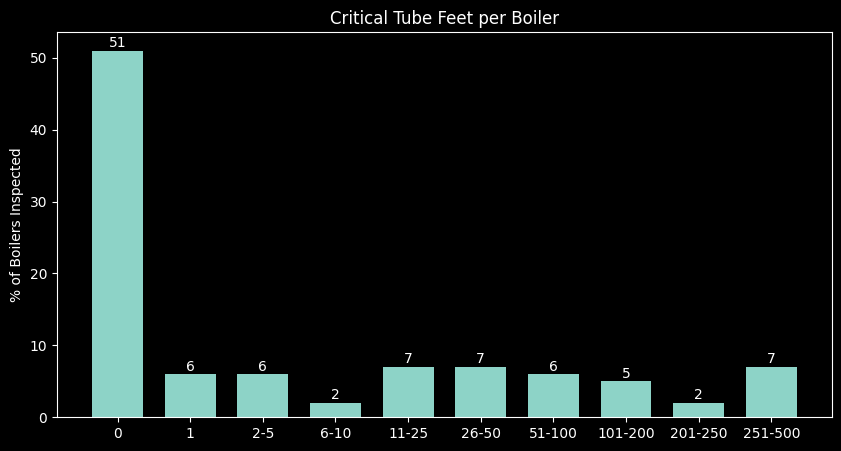

In [89]:
fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = (10,5)
width =0.7

rects1 = ax.bar(x, yp, width)

add_vbar_labels(x, yp)

ax.grid(
    False#, color='gray', linestyle='dashed'
)

ax.set_title('Critical Tube Feet per Boiler')
ax.set_ylabel('% of Boilers Inspected')
#ax.set_xlabel('Critical Tube-Feet')

In [55]:
unit_grouped_crits[unit_grouped_crits['Bins w 40% Loss'] < 1000].shape

(252, 2)

In [ ]:
IIR_ID_all_df = pd.read_csv('../data/outputs/mapped_us_boilers_12523.csv')

In [ ]:
IIR_unit_map_df = IIR_ID_all_df.loc[:,('IIR_UNIT_ID', 'Unit.slug')].drop_duplicates()
IIR_unit_map_df.shape

In [ ]:
iir_mapped_comb_df = comb_df.merge(IIR_unit_map_df, how='left', left_on='entry.tags.unit', right_on='Unit.slug')

In [ ]:
enriched_boiler_inspections_df = iir_mapped_comb_df.merge(us_boilers_df, how='left', left_on='IIR_UNIT_ID', right_on='UNIT_ID')

In [ ]:
enriched_boiler_inspections_df.shape

In [ ]:
enriched_boiler_inspections_df.head()

In [ ]:
enriched_boiler_inspections_df.groupby(['BOIL_CONFIG'])['UNIT_ID'].nunique()

In [ ]:
enriched_boiler_inspections_df.groupby(['BOIL_TYPE_Tag'])['UNIT_ID'].nunique()

In [ ]:
enriched_boiler_inspections_df['Component_type'] = enriched_boiler_inspections_df['entry.tags.component'].astype(str).apply(lambda x: determine_component(x))

In [ ]:
enriched_boiler_inspections_df['Power_Cust'] = enriched_boiler_inspections_df['links.organization.data.portal.name'].isin(POWER_CUST_LIST)

In [ ]:
#set(enriched_boiler_inspections_df['entry.tags.component'])

In [ ]:
#enriched_boiler_inspections_df.groupby(['Component_type'])['slug'].nunique()

In [ ]:
enriched_boiler_inspections_df.groupby(['Power_Cust'])['slug'].nunique()

In [ ]:
enriched_boiler_inspections_df.to_csv('../data/outputs/enriched_boiler_inspections_df.csv')

In [ ]:
# enriched_boiler_inspections_df.loc[:,('Customer.name', 'Location.name')].drop_duplicates().sort_values(['Customer.name', 'Location.name']).to_csv('../data/intermediate/distinct_plants.csv')

Terminology from Tags in BOIL_INFO from IIR

SCR = Selective Catalytic Reduction

SOFA = Separated Over-Fire Air

SNCR = Selective Noncatalytic Reduction

LNB = Low NOX Burners

FGR = Flue Gas Recirculation

BFB = bubbling fluidized bed

BAG ? - baghouse for bagging emissions



In [ ]:
enriched_boiler_inspections_df[enriched_boiler_inspections_df['Component_type'].isin(['Slope', 'Wall'])].groupby(['FUEL_GROUP'])['crits_per10k'].median().to_frame()

In [ ]:
enriched_boiler_inspections_df[enriched_boiler_inspections_df['Component_type'].isin(['Slope', 'Wall'])].groupby(['FUEL_GROUP'])['slug'].nunique().to_frame()

In [ ]:
enriched_boiler_inspections_df[enriched_boiler_inspections_df['Component_type'].isin(['Slope', 'Wall'])].groupby(['FUEL_GROUP'])['crits_per10k'].mean().to_frame()

In [ ]:
enriched_boiler_inspections_df[enriched_boiler_inspections_df['FUEL_GROUP']=='Natural Gas'].shape

In [ ]:
enriched_boiler_inspections_df[enriched_boiler_inspections_df['FUEL_GROUP']=='Natural Gas'].head()

In [ ]:
enriched_boiler_inspections_df[enriched_boiler_inspections_df['FUEL_GROUP']=='Natural Gas'].loc[:, ('links.organization.data.portal.name', 'links.site.data.portal.name', 'links.unit.data.display_name')].drop_duplicates().sort_values(by=['links.organization.data.portal.name', 'links.site.data.portal.name', 'links.unit.data.display_name'])